In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install pytorch-fid

In [ ]:
# Step 1: Import Required Libraries
import torch
from torchvision import models, transforms
from PIL import Image
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
import random
from pytorch_fid import fid_score

In [ ]:
# Device configuration (Using GPU if available, fallback to CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# Step 2: Load Pre-trained VGG19 Model
# Load the pre-trained VGG19 model for feature extraction
vgg = models.vgg19(pretrained=True).features.to(device).eval()

# Freeze all VGG19 parameters
for param in vgg.parameters():
    param.requires_grad = False

# Define layers for extracting content and style features
content_layer = '21'  # conv4_2
style_layers = ['0', '5', '10', '19', '28']  # conv1_1, conv2_1, conv3_1, conv4_1, conv5_1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 108MB/s]


In [ ]:
# Step 3: Helper Functions

def get_features(image, model, layers):
    """Extract features from specified layers."""
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[name] = x
    return features

def gram_matrix(tensor):
    """Compute Gram Matrix for style loss."""
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram / (d * h * w)



In [ ]:
# Step 4: Load and Preprocess Images

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Replace with paths to your content and style folders
content_folder_path = "/content/drive/MyDrive/Applied ML/data/photo_jpg"
style_folder_path = "/content/drive/MyDrive/Applied ML/data/monet_jpg"
generated_images_path = "/content/drive/MyDrive/Applied ML/data/stylized_jpg_ver4"  # Path to generated images


# Ensure generated images folder exists
os.makedirs(generated_images_path, exist_ok=True)

# Load and preprocess content and style images
def load_images_from_folder(folder_path):
    images = []
    file_names = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if file_name.endswith(('.jpg', '.png', '.jpeg')):
            image = transform(Image.open(file_path).convert("RGB"))
            images.append(image)
            file_names.append(file_name)
    return images, file_names

content_images, content_file_names = load_images_from_folder(content_folder_path)
style_images, style_file_names = load_images_from_folder(style_folder_path)

# Limit the number of content images to process
content_images = content_images[:1000]
content_file_names = content_file_names[:1000]

# Define weights for content and style losses
style_weight = 2e7  # Increase from 1e7
content_weight = 5e2  # Decrease from 1e3

In [ ]:
# Step 5: Process All Content Images with Multiple Style Images

# Iterate over all content images
for idx, content_image in enumerate(content_images):
    content_image = content_image.unsqueeze(0).to(device)
    target = content_image.clone().requires_grad_(True).to(device)

    # Randomly select a style image for each content image
    random_style_image = random.choice(style_images).unsqueeze(0).to(device)

    # Extract style features and Gram matrices for the selected style image
    style_features = get_features(random_style_image, vgg, style_layers)
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_layers}

    # Extract content features for the current content image
    content_features = get_features(content_image, vgg, [content_layer])

    # Optimizer
    optimizer = torch.optim.Adam([target], lr=0.01)

    # Training Loop
    steps = 1000
    for step in range(steps):
        # Extract features from the target image
        target_features = get_features(target, vgg, style_layers + [content_layer])

        # Compute content loss
        content_loss = torch.mean((target_features[content_layer] - content_features[content_layer])**2)

        # Compute style loss
        style_loss = 0
        for layer in style_layers:
            target_gram = gram_matrix(target_features[layer])
            style_loss += torch.mean((target_gram - style_grams[layer])**2)
        style_loss *= style_weight

        # Combine losses
        total_loss = content_loss * content_weight + style_loss

        # Update the target image
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Print progress every 1000 steps
        if step % 1000 == 0:
            print(f"Image {idx+1}, Step {step}, Total Loss: {total_loss.item()}")

    # Save the stylized image
    output_file_path = os.path.join(generated_images_path, f"stylized_{content_file_names[idx]}")
    save_image(target, output_file_path)
    print(f"Saved stylized image: {output_file_path}")



Image 1, Step 0, Total Loss: 8498.08984375
Saved stylized image: /content/drive/MyDrive/Applied ML/data/stylized_jpg_ver4/stylized_e4ec14322d.jpg
Image 2, Step 0, Total Loss: 3368.66748046875
Saved stylized image: /content/drive/MyDrive/Applied ML/data/stylized_jpg_ver4/stylized_d4471a4a4e.jpg
Image 3, Step 0, Total Loss: 9762.8271484375
Saved stylized image: /content/drive/MyDrive/Applied ML/data/stylized_jpg_ver4/stylized_de2f9d1599.jpg
Image 4, Step 0, Total Loss: 1451.06005859375
Saved stylized image: /content/drive/MyDrive/Applied ML/data/stylized_jpg_ver4/stylized_db2e0f3cdf.jpg
Image 5, Step 0, Total Loss: 991.462646484375
Saved stylized image: /content/drive/MyDrive/Applied ML/data/stylized_jpg_ver4/stylized_df571c611d.jpg
Image 6, Step 0, Total Loss: 906.492919921875
Saved stylized image: /content/drive/MyDrive/Applied ML/data/stylized_jpg_ver4/stylized_c86587b1e8.jpg
Image 7, Step 0, Total Loss: 674.6006469726562
Saved stylized image: /content/drive/MyDrive/Applied ML/data/st

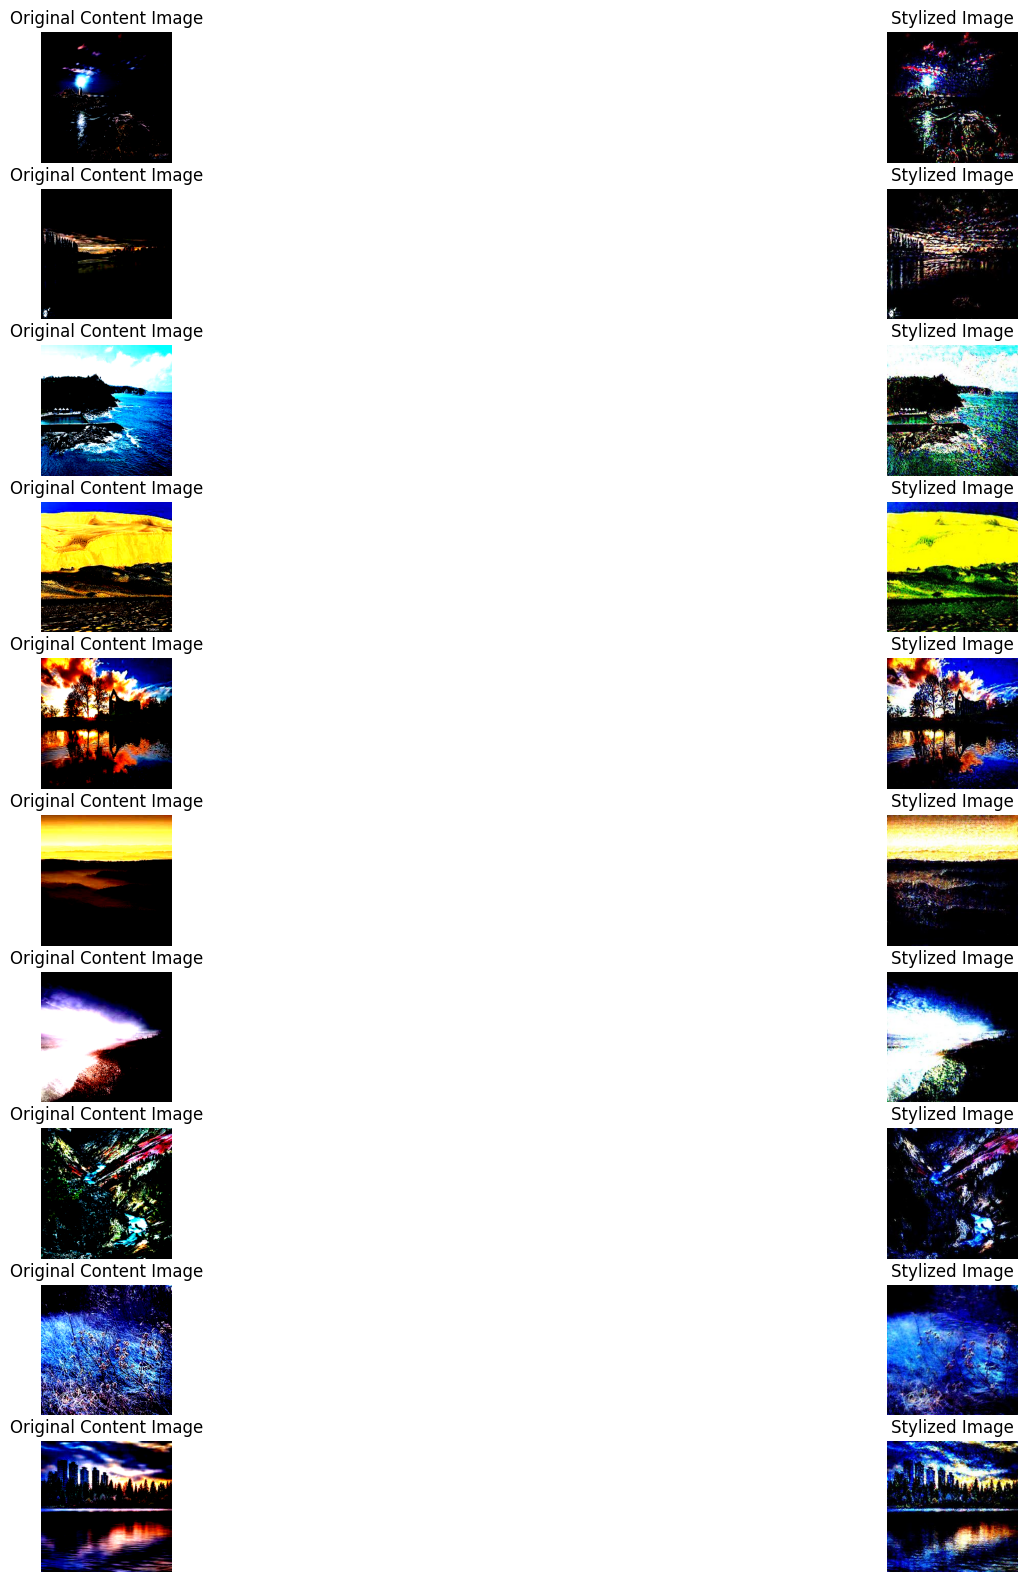

In [ ]:
# Step 6: Visualize Comparisons
plt.figure(figsize=(20, 20))
for i in range(10):
    if i >= len(content_images):
        break
    # Original Content Image
    plt.subplot(10, 2, 2 * i + 1)
    plt.imshow(content_images[i].permute(1, 2, 0).cpu().numpy())
    plt.title("Original Content Image")
    plt.axis("off")

    # Stylized Image
    stylized_image_path = os.path.join(generated_images_path, f"stylized_{content_file_names[i]}")
    stylized_image = Image.open(stylized_image_path)
    plt.subplot(10, 2, 2 * i + 2)
    plt.imshow(stylized_image)
    plt.title("Stylized Image")
    plt.axis("off")
plt.show()



In [ ]:
# Step 7: Calculate Metrics (FID and MFID)
from pytorch_fid import fid_score

# Compute FID
fid = fid_score.calculate_fid_given_paths(
    [style_folder_path, generated_images_path],
    batch_size=1,
    device=device,
    dims=2048
)
print(f"FID Score: {fid}")

# Compute MFID (Custom Implementation)
def calculate_mfid(real_path, generated_path, num_samples=10):
    scores = []
    for _ in range(num_samples):
        score = fid_score.calculate_fid_given_paths([real_path, generated_path], batch_size=1, device=device, dims=2048)
        scores.append(score)
    return sum(scores) / len(scores)

mfid = calculate_mfid(style_folder_path, generated_images_path)
print(f"MFID Score: {mfid}")


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 105MB/s]
100%|██████████| 1000/1000 [00:20<00:00, 48.08it/s]


FID Score: 127.62831754807314


100%|██████████| 1000/1000 [00:20<00:00, 48.82it/s]


MFID Score: 127.62831754807311
